In [1]:
!pip install torch transformers matplotlib pandas scipy -q

Using device: cuda
Initializing model...
Model parameters: 1.24B

Starting training with detailed memory tracking...

Step 1/4
  Loss: 10.5428
  Peak memory: 36.62GB

Step 2/4
  Loss: 10.5392
  Peak memory: 46.54GB

Step 3/4
  Loss: 10.5463
  Peak memory: 46.54GB

Step 4/4
  Loss: 10.5231
  Peak memory: 46.54GB

Training completed!


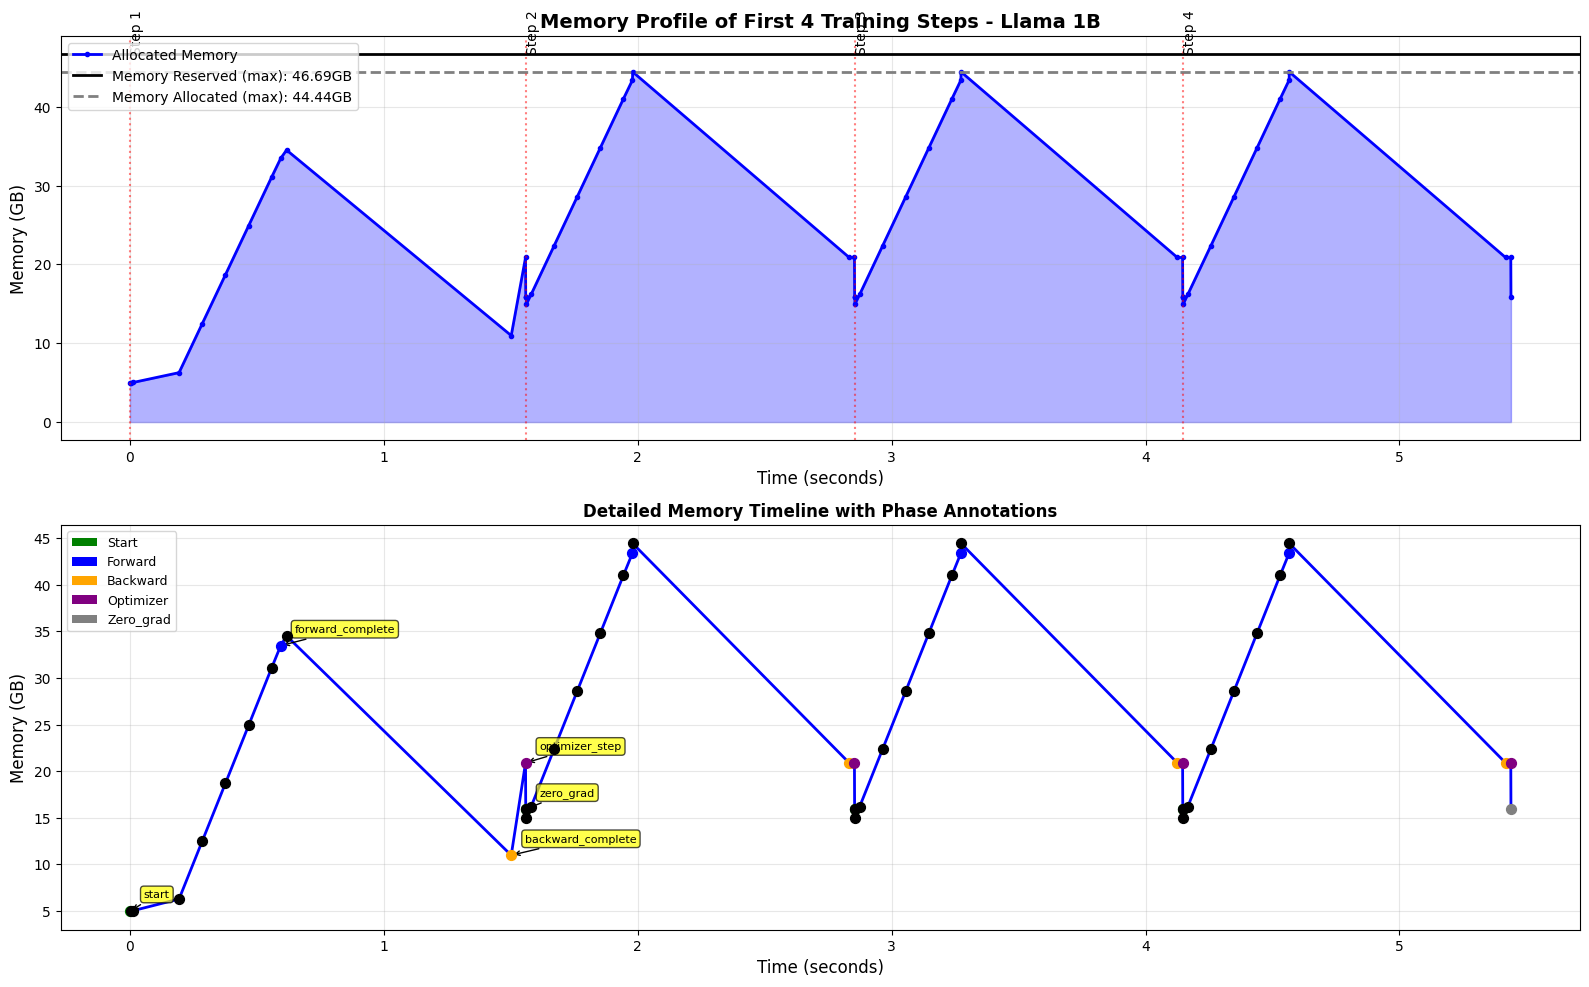


✓ Detailed memory profile saved as 'llama_memory_profile_detailed.png'

Marking phase transitions for steps 2 and 3...

Step 2 snapshots found: 13
  Forward complete: 1 snapshots
  Backward complete: 1 snapshots
  Optimizer step: 1 snapshots
  FP ends at: 1.979s
  BP ends at: 2.833s
  OPT begins at: 2.854s

Step 3 snapshots found: 13
  Forward complete: 1 snapshots
  Backward complete: 1 snapshots
  Optimizer step: 1 snapshots
  FP ends at: 3.273s
  BP ends at: 4.125s
  OPT begins at: 4.146s


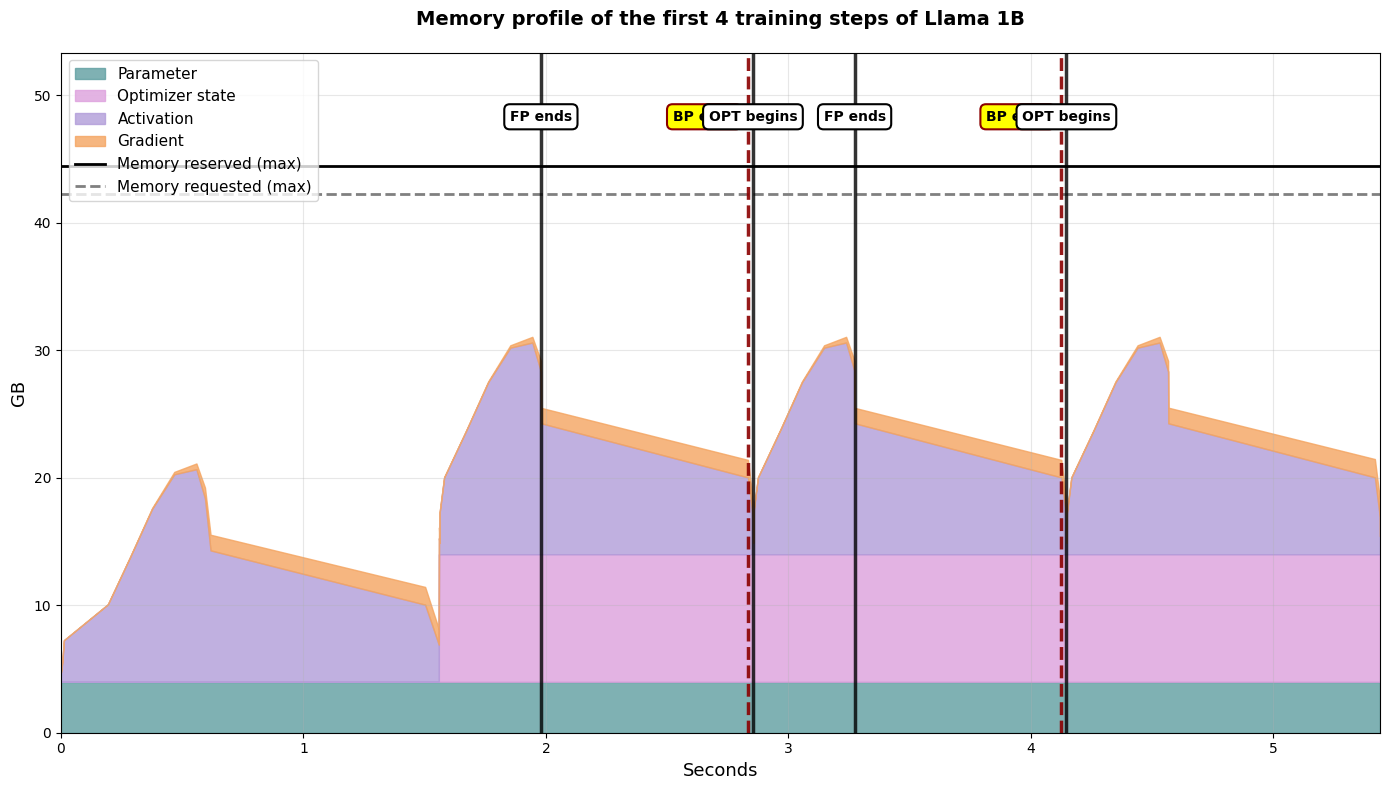

✓ Stacked area chart saved as 'llama_memory_profile_stacked.png'

Memory Summary:
Peak allocated: 44.44 GB
Peak reserved: 46.69 GB
Total snapshots collected: 52
Total training time: 5.44 seconds


In [2]:
# Install required packages (if needed)
# !pip install torch transformers matplotlib pandas -q

import torch
import torch.nn as nn
from torch.profiler import profile, ProfilerActivity, schedule
import matplotlib.pyplot as plt
import numpy as np
import time

# Create a simplified Llama-like model (1B parameters approximation)
class SimplifiedLlama1B(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(32000, 2048)
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=2048, nhead=16, dim_feedforward=8192, batch_first=True)
            for _ in range(22)
        ])
        self.norm = nn.LayerNorm(2048)
        self.lm_head = nn.Linear(2048, 32000, bias=False)

    def forward(self, x):
        x = self.embed(x)
        for layer in self.layers:
            x = layer(x)
        x = self.norm(x)
        return self.lm_head(x)

# Memory snapshot collector
class MemoryProfiler:
    def __init__(self):
        self.snapshots = []
        self.start_time = None

    def start(self):
        self.start_time = time.time()
        self.snapshots = []

    def snapshot(self, label=""):
        if self.start_time is None:
            self.start_time = time.time()

        torch.cuda.synchronize()
        current_time = time.time() - self.start_time

        # Get detailed memory stats
        allocated = torch.cuda.memory_allocated() / 1e9
        reserved = torch.cuda.max_memory_reserved() / 1e9

        # Get memory summary
        stats = torch.cuda.memory_stats()

        self.snapshots.append({
            'time': current_time,
            'label': label,
            'allocated': allocated,
            'reserved': reserved,
            'active_bytes': stats.get('active_bytes.all.current', 0) / 1e9,
            'inactive_bytes': stats.get('inactive_split_bytes.all.current', 0) / 1e9,
        })

    def get_snapshots(self):
        return self.snapshots

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if device.type != 'cuda':
    print("WARNING: CUDA not available. Memory profiling requires GPU!")
else:
    # Clear cache and reset stats
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.reset_accumulated_memory_stats()

    print("Initializing model...")
    model = SimplifiedLlama1B().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

    batch_size = 4
    seq_length = 2048

    print(f"Model parameters: {sum(p.numel() for p in model.parameters()) / 1e9:.2f}B")

    # Create profiler
    mem_profiler = MemoryProfiler()
    mem_profiler.start()

    print("\nStarting training with detailed memory tracking...")
    print("="*60)

    # Training loop with frequent memory snapshots
    for step in range(4):
        print(f"\nStep {step + 1}/4")

        mem_profiler.snapshot(f"step{step+1}_start")

        # Generate data
        input_ids = torch.randint(0, 32000, (batch_size, seq_length), device=device)
        labels = torch.randint(0, 32000, (batch_size, seq_length), device=device)

        mem_profiler.snapshot(f"step{step+1}_data_loaded")

        # Forward pass with intermediate snapshots
        outputs = model.embed(input_ids)
        mem_profiler.snapshot(f"step{step+1}_after_embed")

        # Through transformer layers
        for i, layer in enumerate(model.layers):
            outputs = layer(outputs)
            if i % 5 == 0:  # Sample every 5 layers
                mem_profiler.snapshot(f"step{step+1}_layer{i}")

        outputs = model.norm(outputs)
        outputs = model.lm_head(outputs)
        mem_profiler.snapshot(f"step{step+1}_forward_complete")

        # Loss computation
        loss = nn.functional.cross_entropy(outputs.view(-1, 32000), labels.view(-1))
        mem_profiler.snapshot(f"step{step+1}_loss_computed")

        # Backward pass
        loss.backward()
        mem_profiler.snapshot(f"step{step+1}_backward_complete")

        # Optimizer step
        optimizer.step()
        mem_profiler.snapshot(f"step{step+1}_optimizer_step")

        optimizer.zero_grad()
        mem_profiler.snapshot(f"step{step+1}_zero_grad")

        print(f"  Loss: {loss.item():.4f}")
        print(f"  Peak memory: {torch.cuda.max_memory_allocated() / 1e9:.2f}GB")

    print("\n" + "="*60)
    print("Training completed!")
    print("="*60)

    # Get all snapshots
    snapshots = mem_profiler.get_snapshots()

    # Create detailed visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

    # Extract data
    times = [s['time'] for s in snapshots]
    allocated = [s['allocated'] for s in snapshots]
    reserved = [s['reserved'] for s in snapshots]
    labels = [s['label'] for s in snapshots]

    # Plot 1: Total memory over time
    ax1.plot(times, allocated, 'b-', linewidth=2, label='Allocated Memory', marker='o', markersize=3)
    ax1.fill_between(times, 0, allocated, alpha=0.3, color='blue')
    ax1.axhline(y=max(reserved), color='black', linestyle='-', linewidth=2,
                label=f'Memory Reserved (max): {max(reserved):.2f}GB')
    ax1.axhline(y=max(allocated), color='gray', linestyle='--', linewidth=2,
                label=f'Memory Allocated (max): {max(allocated):.2f}GB')

    # Mark step boundaries
    step_times = [s['time'] for s in snapshots if 'start' in s['label']]
    for i, st in enumerate(step_times):
        ax1.axvline(x=st, color='red', linestyle=':', alpha=0.5)
        ax1.text(st, max(allocated)*1.05, f'Step {i+1}', rotation=90, va='bottom')

    ax1.set_xlabel('Time (seconds)', fontsize=12)
    ax1.set_ylabel('Memory (GB)', fontsize=12)
    ax1.set_title('Memory Profile of First 4 Training Steps - Llama 1B', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)

    # Plot 2: Detailed view with phase markers
    ax2.plot(times, allocated, 'b-', linewidth=2, marker='o', markersize=4)

    # Color code by phase
    phase_colors = {
        'start': 'green',
        'forward': 'blue',
        'backward': 'orange',
        'optimizer': 'purple',
        'zero_grad': 'gray'
    }

    for i, (t, a, lbl) in enumerate(zip(times, allocated, labels)):
        color = 'black'
        for phase, col in phase_colors.items():
            if phase in lbl:
                color = col
                break
        ax2.scatter(t, a, c=color, s=50, zorder=5)

    # Annotate key points
    key_points = [s for s in snapshots if any(x in s['label'] for x in
                  ['start', 'forward_complete', 'backward_complete', 'optimizer_step', 'zero_grad'])]

    for point in key_points:
        if 'step1' in point['label']:  # Only annotate step 1 for clarity
            label_text = point['label'].replace('step1_', '')
            ax2.annotate(label_text,
                        xy=(point['time'], point['allocated']),
                        xytext=(10, 10), textcoords='offset points',
                        fontsize=8, bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    ax2.set_xlabel('Time (seconds)', fontsize=12)
    ax2.set_ylabel('Memory (GB)', fontsize=12)
    ax2.set_title('Detailed Memory Timeline with Phase Annotations', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)

    # Add legend for phases
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color, label=phase.capitalize())
                      for phase, color in phase_colors.items()]
    ax2.legend(handles=legend_elements, loc='upper left', fontsize=9)

    plt.tight_layout()
    plt.savefig('llama_memory_profile_detailed.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✓ Detailed memory profile saved as 'llama_memory_profile_detailed.png'")

    # Create the stacked area chart similar to the reference image
    fig, ax = plt.subplots(figsize=(14, 8))

    # Analyze memory components across steps
    # Separate first step from subsequent steps
    step1_snapshots = [s for s in snapshots if 'step1' in s['label']]
    step2_snapshots = [s for s in snapshots if 'step2' in s['label']]
    step3_snapshots = [s for s in snapshots if 'step3' in s['label']]
    step4_snapshots = [s for s in snapshots if 'step4' in s['label']]

    all_times = times
    all_allocated = allocated

    # Estimate memory components based on phase
    param_memory = np.ones(len(times)) * 4.0  # Base parameter memory
    optimizer_memory = np.zeros(len(times))
    activation_memory = np.zeros(len(times))
    gradient_memory = np.zeros(len(times))

    for i, snap in enumerate(snapshots):
        label = snap['label']
        alloc = snap['allocated']

        # After first optimizer step, optimizer state exists
        if 'step1' in label and 'optimizer_step' in label:
            opt_mem_start = i

        if i > 0 and any(f'step{s}_optimizer_step' in snapshots[j]['label']
                        for s in range(1, 5) for j in range(i)):
            optimizer_memory[i] = 10.0

        # Estimate activations (difference during forward pass)
        if 'forward' in label or 'layer' in label:
            activation_memory[i] = max(0, alloc - param_memory[i] - optimizer_memory[i])

        # Estimate gradients (during backward)
        if 'backward' in label:
            gradient_memory[i] = max(0, alloc - param_memory[i] - optimizer_memory[i] - activation_memory[i])

    # Smooth the data
    from scipy.ndimage import gaussian_filter1d
    activation_memory = gaussian_filter1d(activation_memory, sigma=2)
    gradient_memory = gaussian_filter1d(gradient_memory, sigma=2)

    # Create stacked area plot
    ax.fill_between(times, 0, param_memory, label='Parameter', color='#5F9EA0', alpha=0.8)
    ax.fill_between(times, param_memory, param_memory + optimizer_memory,
                    label='Optimizer state', color='#DDA0DD', alpha=0.8)
    ax.fill_between(times, param_memory + optimizer_memory,
                    param_memory + optimizer_memory + activation_memory,
                    label='Activation', color='#B19CD9', alpha=0.8)
    ax.fill_between(times, param_memory + optimizer_memory + activation_memory,
                    param_memory + optimizer_memory + activation_memory + gradient_memory,
                    label='Gradient', color='#F4A460', alpha=0.8)

    # Add reference lines
    max_mem = max(allocated)
    ax.axhline(y=max_mem, color='black', linestyle='-', linewidth=2,
               label=f'Memory reserved (max)')
    ax.axhline(y=max_mem*0.95, color='gray', linestyle='--', linewidth=2,
               label=f'Memory requested (max)')

    # Mark phases for 2nd and 3rd steps (more visible)
    print("\nMarking phase transitions for steps 2 and 3...")
    for step_num in [2, 3]:  # Mark steps 2 and 3
        step_snapshots = [s for s in snapshots if f'step{step_num}' in s['label']]
        print(f"\nStep {step_num} snapshots found: {len(step_snapshots)}")

        if len(step_snapshots) > 3:
            # FP ends (peak of forward pass)
            fwd_snapshots = [s for s in step_snapshots if 'forward_complete' in s['label']]
            # BP ends
            bwd_snapshots = [s for s in step_snapshots if 'backward_complete' in s['label']]
            # OPT begins
            opt_snapshots = [s for s in step_snapshots if 'optimizer_step' in s['label']]

            print(f"  Forward complete: {len(fwd_snapshots)} snapshots")
            print(f"  Backward complete: {len(bwd_snapshots)} snapshots")
            print(f"  Optimizer step: {len(opt_snapshots)} snapshots")

            if fwd_snapshots:
                fwd_time = fwd_snapshots[0]['time']
                print(f"  FP ends at: {fwd_time:.3f}s")
                ax.axvline(x=fwd_time, color='black', linewidth=2.5, linestyle='-', alpha=0.8)
                ax.text(fwd_time, max_mem*1.08, 'FP ends', ha='center', fontsize=10,
                       fontweight='bold', bbox=dict(boxstyle='round,pad=0.4',
                       facecolor='white', edgecolor='black', linewidth=1.5))

            if bwd_snapshots:
                bwd_time = bwd_snapshots[0]['time']
                print(f"  BP ends at: {bwd_time:.3f}s")
                # Draw line slightly thinner and with different style
                ax.axvline(x=bwd_time, color='darkred', linewidth=2.5, linestyle='--', alpha=0.9)
                # Offset label to avoid overlap
                ax.text(bwd_time - 0.05, max_mem*1.08, 'BP ends', ha='right', fontsize=10,
                       fontweight='bold', bbox=dict(boxstyle='round,pad=0.4',
                       facecolor='yellow', edgecolor='darkred', linewidth=1.5))
            else:
                print(f"  WARNING: No backward_complete snapshot found for step {step_num}")

            if opt_snapshots:
                opt_time = opt_snapshots[0]['time']
                print(f"  OPT begins at: {opt_time:.3f}s")
                ax.axvline(x=opt_time, color='black', linewidth=2.5, linestyle='-', alpha=0.8)
                ax.text(opt_time, max_mem*1.08, 'OPT begins', ha='center', fontsize=10,
                       fontweight='bold', bbox=dict(boxstyle='round,pad=0.4',
                       facecolor='white', edgecolor='black', linewidth=1.5))

    ax.set_xlabel('Seconds', fontsize=13)
    ax.set_ylabel('GB', fontsize=13)
    ax.set_xlim(0, max(times))
    ax.set_ylim(0, max_mem * 1.2)
    ax.legend(loc='upper left', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_title('Memory profile of the first 4 training steps of Llama 1B',
                fontsize=14, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.savefig('llama_memory_profile_stacked.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Stacked area chart saved as 'llama_memory_profile_stacked.png'")

    # Print summary
    print(f"\n{'='*60}")
    print("Memory Summary:")
    print(f"{'='*60}")
    print(f"Peak allocated: {max(allocated):.2f} GB")
    print(f"Peak reserved: {max(reserved):.2f} GB")
    print(f"Total snapshots collected: {len(snapshots)}")
    print(f"Total training time: {max(times):.2f} seconds")